In [1]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math

#import data
from biom import load_table
from gneiss.util import match
#deicode
from deicode.optspace import OptSpace
from deicode.utils import get_enriched_labels,get_mean_abundance,get_lowest_level,get_taxa
from deicode.preprocessing import rclr,inverse_rclr
#transforms 
from skbio.stats.composition import clr,ilr,centralize, ilr_inv,closure
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
#else
#regression
from gneiss.regression import ols
from gneiss.composition import ilr_transform
from gneiss.cluster import correlation_linkage

%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")



 Sponges (case study)

The Sponge Microbiome (Qiita Project - ID 10793). 

"Here, we provide a dataset that will facilitate microbiome comparisons across large spatial, temporal and environmental scales."

Lucas Moitinho (U NSW) (University of New South Wales) [Data and Source](https://qiita.ucsd.edu/study/description/10793)

First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [2]:
from biom import load_table
from gneiss.util import match

# import observation data
in_biom='data/sponge/sponge_table.biom' #import biom file
table = load_table(in_biom)
sample_filter = lambda val, id_, md: sum(val) > 500
table = table.filter(sample_filter, axis='sample')
otutabledf=table.to_dataframe().T.drop_duplicates()

# Get OTU to taxa match
taxonomy=get_taxa(table.metadata_to_dataframe('observation'))

#mapping import 
map_file='data/sponge/sponge_mapping.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf)


Now we can extract OTUs (features) that separate sponges across life stages.

We want to see if life stage is an important category. We would also like to find out what pattern of OTUs best explain possible variation between life stages. In this case we use a rank of 2 because life stage has two possible classes; Adult or Larvae.

In [82]:
# rclr preprocessing
table_norm=rclr().fit_transform(otutabledf.copy())
# OptSpace (RPCA)
opt=OptSpace().fit(table_norm)

#Sample Loadings 
sample_loading=pd.DataFrame(opt.sample_weights,index=otutabledf.index)
sample_loading = sample_loading.rename(columns={0: 'PC1', 1: 'PC2'})

#Feature Loadings 
feature_loading=pd.DataFrame(opt.feature_weights,index=otutabledf.columns).sort_values(by=0)

# Euclidean Distance 
euc_dist=pdist(otutabledf.as_matrix(), 'euclidean')
# Bray-Curtis Distance           
bray_dist=pdist(otutabledf.as_matrix(), 'braycurtis')

# Sort the metadata by solid food class (Pre and Post)
life_stage = mappingdf['life_stage'].sort_values()
          
# view a sample of loadings
sample_loading.head(5)

,PC1,PC2
10793.Webster.4.H11.No.sample.1182376,-0.024881,1.157352
10793.Webster.3.B8.208.1181868,-0.918548,1.070087
10793.Webster.4.G9.363.1181823,-0.454689,0.835357
10793.Webster.1.B1.13.1182163,-0.087789,0.058886
10793.Webster.4.B12.306.1181787,-1.636922,0.701875


### Calculate _permanova_ stats

In [83]:
from scipy.spatial import distance
from skbio.stats.distance import permanova

#RPCA
rpca_dist=DistanceMatrix(opt.distance,list(otutabledf.index))
rpca_distp=permanova(rpca_dist,mappingdf.life_stage.values)

#Euclidean
euc_dist=DistanceMatrix(euc_dist,list(otutabledf.index))
euc_distp=permanova(euc_dist,mappingdf.life_stage.values)

#Bray
bray_dist=DistanceMatrix(bray_dist,list(otutabledf.index))
bray_distp=permanova(bray_dist,mappingdf.life_stage.values)

#Get the Qiita Generated Weighted UniFrac and make sure it is matched
unifrac_weighted_dist=pd.read_csv('data/sponge/Qiita_weighted_uni.tsv',index_col=0)
unifrac_weighted_dist=unifrac_weighted_dist.reindex(index=otutabledf.index,columns=otutabledf.index)
unifrac_weighted_dist=DistanceMatrix(unifrac_weighted_dist,list(otutabledf.index))
weighted_permp=permanova(unifrac_weighted_dist,mappingdf.life_stage.values)

permres=np.around(np.array([[rpca_distp['p-value'],rpca_distp['test statistic']],
         [euc_distp['p-value'],euc_distp['test statistic']],
         [bray_distp['p-value'],bray_distp['test statistic']],
         [weighted_permp['p-value'],weighted_permp['test statistic']]]),3)

permres=pd.DataFrame(permres,index=['RPCA','Euclidean','Bray-Curtis','Weighted UniFrac']
                     ,columns=['p-value','pseudo-F']).sort_values('pseudo-F',ascending=False)
permres


,p-value,pseudo-F
RPCA,0.001,93.784
Weighted UniFrac,0.001,39.564
Bray-Curtis,0.001,21.824
Euclidean,0.001,12.148


#### Plot Ordination Results


In [80]:
def plot_lifestage(samples, md, ax):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    idx = md['life_stage'] == 'Adult'
    ax.scatter(samples.loc[idx, 'PC1'], samples.loc[idx, 'PC2'], label='Adult',c='#1f78b4',alpha=.7)   
    ax.scatter(samples.loc[~idx, 'PC1'], samples.loc[~idx, 'PC2'], label='Larvae',c='#e31a1c',alpha=.7)    
    
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel('PC2', fontsize=18)    
    ax.set_xlabel('PC1', fontsize=18)
    return ax

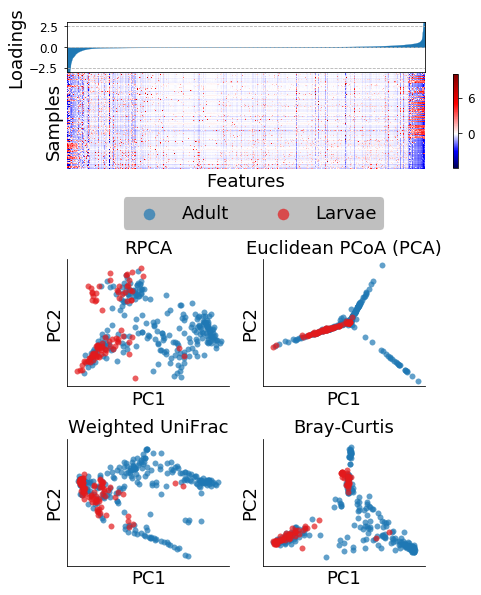

In [81]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('seaborn-paper')

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


fig = plt.figure(figsize=(7, 10), facecolor='white')
gs = gridspec.GridSpec(85, 60)
ax_map = plt.subplot(gs[8:23, :55])
ax_bar = plt.subplot(gs[0:8, :55])
ax_cbar = plt.subplot(gs[8:23, 55:])

ax_raw_complete = plt.subplot(gs[37:57, :25])
ax_raw_bray = plt.subplot(gs[37:57, 30:55])
ax_raw_uni = plt.subplot(gs[65:85, :25])
ax_raw_uni_un = plt.subplot(gs[65:85, 30:55])

ind = np.arange(feature_loading.shape[0])
ax_bar.stackplot(ind, feature_loading[0],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
ax_bar.set_xticks([])

ax_bar.set_ylim([-3, 3])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('Loadings', fontsize=18)
ax_bar.tick_params(labelsize=12)

sorted_df = otutabledf.reindex(index=life_stage.index, columns=feature_loading.index)
sorted_df = sorted_df.loc[:, sorted_df.sum(axis=0) > 50] #make clusters more evident 
img = ax_map.imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                    norm=MidpointNormalize(midpoint=0.),
                    interpolation='nearest', cmap='seismic')

ax_map.set_xticks([])
ax_map.set_yticks([])
ax_map.set_xlabel('Features', fontsize=18)
ax_map.set_ylabel('Samples', fontsize=18)
ax_map.spines['right'].set_visible(False)
ax_map.spines['top'].set_visible(False)
ax_map.spines['bottom'].set_visible(False)
ax_map.spines['left'].set_visible(False)
ax_map.grid()

cbar = fig.colorbar(img, ax=ax_cbar) 
cbar.ax.tick_params(labelsize=12)
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])
ax_cbar.axis('off')
ax_cbar.grid()
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])

# get pcoa for unifrac
unifrac_weighted_pcoa=pcoa(unifrac_weighted_dist).samples
unifrac_weighted_pcoa.index=list(mappingdf.index)

ax_raw_complete = plot_lifestage(pcoa(rpca_dist).samples, mappingdf, ax_raw_complete)
ax_raw_bray = plot_lifestage(pcoa(euc_dist).samples, mappingdf, ax_raw_bray)
ax_raw_uni = plot_lifestage(pcoa(unifrac_weighted_dist).samples, mappingdf, ax_raw_uni)
ax_raw_uni_un = plot_lifestage(pcoa(bray_dist).samples, mappingdf, ax_raw_uni_un)

ax_raw_uni.set_title('Weighted UniFrac', fontsize=18)
ax_raw_uni_un.set_title('Bray-Curtis', fontsize=18)
ax_raw_complete.set_title('RPCA', fontsize=18)
ax_raw_bray.set_title('Euclidean PCoA (PCA)', fontsize=18)

ax_raw_uni_un.legend(loc=1,bbox_to_anchor=(.8, 2.97),prop={'size':18},
                     fancybox=True, framealpha=0.5,ncol=2
                     , markerscale=2, facecolor="grey")

fig.savefig('figures/figure3A.png',dpi=300, bbox_inches='tight',facecolor='white')
plt.show()


#### plot the taxonomy seperated by the feature weights

In [7]:
cutoff_=9.44
features=get_enriched_labels(feature_loading.copy(),cutoff=cutoff_)
mean_abundances=get_mean_abundance(otutabledf,mappingdf,features,'life_stage')
index_level_tax=get_lowest_level(taxonomy,features,default_highest=-5)

#group by lowest level
mean_abundances.index=[index_level_tax[i] for i in mean_abundances.index]
mean_abundances=mean_abundances.groupby(mean_abundances.index).sum()


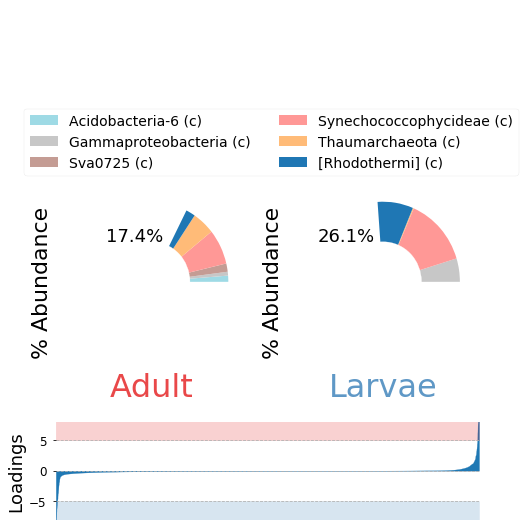

In [8]:

fig = plt.figure(figsize=(8, 10), facecolor='white')
gs = gridspec.GridSpec(16, 58)

ax_legend = plt.subplot(gs[0:4, :55])
ax_bar = plt.subplot(gs[12:15, :55])
ax_group1 = plt.subplot(gs[5:11, :25])
ax_group2 = plt.subplot(gs[5:11, 30:55])

ind = np.arange(feature_loading.shape[0])
ax_bar.stackplot(ind, feature_loading[0],color='#1f78b4',alpha=1)
ax_bar.set_xlim([0, feature_loading.shape[0]])
ax_bar.set_ylim([feature_loading[0].min(), feature_loading[0].max()])
ax_bar.set_xticks([])
ax_bar.axhline(cutoff_,lw=4,ls='--',color="#e41a1c",alpha=.2)
ax_bar.axhline(-cutoff_,lw=4,ls='--',color="#377eb8",alpha=.2)
ax_bar.fill_between(ind, 5,feature_loading[0].max(), color="#e41a1c",alpha=.2)  
ax_bar.fill_between(ind, -5,feature_loading[0].min(), color="#377eb8",alpha=.2)  
ax_bar.set_ylim([-8, 8])
ax_bar.grid(which='major', axis='both', linestyle='--')
ax_bar.set_ylabel('Loadings', fontsize=18)
ax_bar.tick_params(labelsize=12)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.spines['left'].set_visible(False)

locs=[(-.6,.5),(-.85,.5)]
percs=[str(x)[:4]+'%' for x in list(mean_abundances.sum())]
for (count_,group_),ax,cols_ in zip(enumerate(mean_abundances.columns),
                             [ax_group1,ax_group2]
                                   ,['#e41a1c','#377eb8']):
    all_pie=mean_abundances.copy()
    
    all_pie[group_]=all_pie[group_]/100
    
    # Create a circle for the center of the plot
    my_circle=plt.Circle( (0,0), 0.5, color='white')

    all_pie[group_].T.plot.pie(ax=ax,
                                    labels=['' for x in mean_abundances[group_].values],
                                   colormap='tab20_r')

    ax.set_ylabel('% Abundance',fontsize=22)
    ax.add_artist(my_circle)
    ax.annotate(percs[count_], locs[count_],fontsize=18)
    ax.set_title(group_,fontsize=32,y=-.10,color=cols_,alpha=.8)
    
ax_group1.legend(labels=all_pie.index,title=""
                 , loc=2,prop={'size':14}
                 ,bbox_to_anchor=(-0.2, 1.4),
                ncol=math.floor(np.sqrt(len(mean_abundances.index)))) 

ax_legend.grid()
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.axis('off')
ax_legend.grid()
ax_legend.set_xticks([])
ax_legend.set_yticks([])
fig.savefig('figures/figure4A.png',dpi=300, bbox_inches='tight',facecolor='white')
plt.show()

### Supplemental Figures

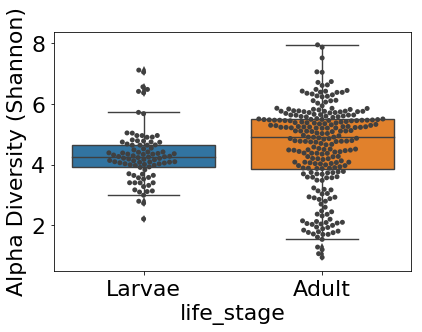

In [9]:
from skbio.diversity import alpha_diversity

plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22



alpha_=list(alpha_diversity('shannon',otutabledf.fillna(0).astype(int).as_matrix(),otutabledf.index).values)  
mappingdf['Alpha Diversity (Shannon)']=alpha_
sns.boxplot(y='Alpha Diversity (Shannon)',x='life_stage',data=mappingdf)
sns.swarmplot(y='Alpha Diversity (Shannon)',x='life_stage',data=mappingdf, color=".25")
plt.savefig('figures/supp_sponge_alpha.png',dpi=300, bbox_inches='tight')
plt.show()

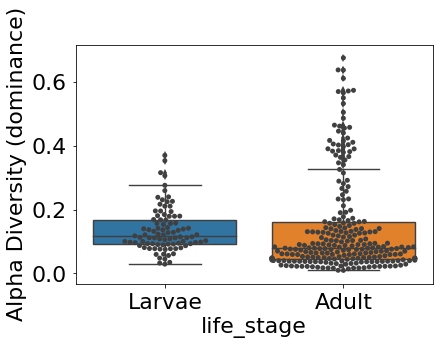

In [10]:
from skbio.diversity import alpha_diversity

plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22



alpha_=list(alpha_diversity('dominance',otutabledf.fillna(0).astype(int).as_matrix(),otutabledf.index).values)  
mappingdf['Alpha Diversity (dominance)']=alpha_
sns.boxplot(y='Alpha Diversity (dominance)',x='life_stage',data=mappingdf)
sns.swarmplot(y='Alpha Diversity (dominance)',x='life_stage',data=mappingdf, color=".25")
plt.savefig('figures/supp_sponge_dom.png',dpi=300, bbox_inches='tight')
plt.show()